In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# PETSc Time-stepping Solver -- Chemical Akzo Nobel Example
Author: John Eslick  
Maintainer: John Eslick  
Updated: 2023-06-01  

This example provides an overview of the PETSc time-stepping solver utilities in IDAES, which can be used to solve systems of differential algebraic equations (DAEs). PETSc is a solver suite developed primarily by Argonne National Lab (https://petsc.org/release/). IDAES provides a wrapper for PETSc (https://github.com/IDAES/idaes-ext/tree/main/petsc) that uses the AMPL solver interface (https://ampl.com/resources/learn-more/hooking-your-solver-to-ampl/) and utility functions that allow Pyomo and Pyomo.DAE (https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html) problems to be solved using PETSc.

This demonstration problem describes a set of chemical reactions in a reactor. A full description of the problem is available at https://archimede.dm.uniba.it/~testset/report/chemakzo.pdf. This is part of a test set which can be found at https://archimede.uniba.it/~testset/.

## Prerequisites

The PETSc solver is an extra download for IDAES, which can be downloaded using the command ```idaes get-extensions --extra petsc```, if it is not installed already. See the IDAES solver documentation for more information (https://idaes-pse.readthedocs.io/en/stable/reference_guides/core/solvers.html).

## Imports

Import the modules that will be used.  Numpy and matplotlib are used to make some plots, ```idaes.core.solvers.petsc``` contains the PETSc utilities, and ```idaes.core.solvers.features``` contains the example model used here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import idaes.core.solvers.petsc as petsc  # petsc utilities module
from idaes.core.solvers.features import dae  # DAE example/test problem

## Set Up the Model

The model in this example is used for basic solver testing, so it is provided as part of an IDAES solver testing module. The model implementation is standard Pyomo.DAE, and nothing special needs to be done in the model to use the PETSc solver.  The IDAES utilities for the PETSc solver will take the discretized Pyomo model and integrate between discrete time points to fill in the solution. To integrate over the entire time domain (as we will do here), you can discretize time using one time element, in which case, the problem will just contain the initial and final points.  The intermediate solutions can be read from the trajectory data saved by the solver.  The trajectory data can be used for analysis, or interpolation can be used to initialize a Pyomo problem before solving the fully time discretized problem.  Integrating over the entire time domain is fastest with a coarsely discretized model (ideally just a single finite element in time) because the model is smaller and there are fewer calls to the integrator.  This can be a good way to start testing a new dynamic IDAES model.

In [3]:
# To see the example problem code, uncomment the line below and execute this cell.
# ??dae

In [4]:
# Get the model and known solution for y variables at t=180 minutes.
m, y1, y2, y3, y4, y5, y6 = dae(nfe=10)

The variables y1 to y6 represent concentrations of chemical species.  The values returned by the function above are the correct solution at t = 180.  These values can be used to verify the solver results.  The Pyomo model is ``m``.  We are mainly interested in the y variables.  The variables y1 to y5 are differential variables and y6 is an algebraic variable.  Initial conditions are required for y1 through y5, and the initial values of the other variables can be calculated from there.  The variables y1 through y5 at t = 0 are: ``m.y[0, 1]`` to ``m.y[0, 5]`` and y6 is ``m.y6[0]``.  The variables at the final state are ``m.y[180, 1]`` to ``m.y[180, 5]`` and ``m.y6[180]``.  The variable y6 is indexed differently because we want to treat it differently than the differential variables.

In [5]:
# See the initial conditions:
print("at t = 0:")
print(f"    y1 = {pyo.value(m.y[0, 1])}")
print(f"    y2 = {pyo.value(m.y[0, 2])}")
print(f"    y3 = {pyo.value(m.y[0, 3])}")
print(f"    y4 = {pyo.value(m.y[0, 4])}")
print(f"    y5 = {pyo.value(m.y[0, 5])}")

at t = 0:
    y1 = 0.444
    y2 = 0.00123
    y3 = 0.0
    y4 = 0.007
    y5 = 0.0


## Solve

The ``petsc_dae_by_time_element()`` function is used to solve Pyomo.DAE discretized Pyomo problem with the PETSc time-stepping solver by integrating between discrete time points.  In this case there is only one time element.

In [6]:
# To see the docs, uncomment the line below and execute this cell.
# ?petsc.petsc_dae_by_time_element

In [7]:
# The command below will solve the problem.  In this case, we want to read the saved
# trajectory for each time element in the Pyomo.DAE problem (in this case there is
# only 1) so we will need to provide solver options to save the trajectory to the PETSc
# solver, a file name stub for variable information files, and a file stub for saving
# the trajectory information.  The options shown below will delete the trajectory
# information written by PETSc and resave it as json.  This allows us to cleanly read
# the trajectory data for multiple time elements.

result = petsc.petsc_dae_by_time_element(
    m,
    time=m.t,
    between=[m.t.first(), m.t.last()],
    ts_options={
        "--ts_type": "cn",  # Crank–Nicolson
        "--ts_adapt_type": "basic",
        "--ts_dt": 0.01,
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory
res = result.results

2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: DAE: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp79_vpohc.pyomo.nl


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of constraints: 12


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 1


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 11


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of variables: 12


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 30 


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae:   0 SNES Function norm 4.725472106218e+00 


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae:   1 SNES Function norm 6.033402274321e-03 


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae:   2 SNES Function norm 5.511108092160e-19 


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: SNESConvergedReason = SNES_CONVERGED_FNORM_ABS, in 2 iterations


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: SNES_CONVERGED_FNORM_ABS


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp86gcsgoo.pyomo.nl


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of constraints: 12


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 6


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 6


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of variables: 17


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 42 


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Explicit time variable: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 7


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of state vars: 12


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.01 time 0.


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.01 time 0.01


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0253727 time 0.02


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0263136 time 0.0453727


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.0266656 time 0.0716863


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.0273379 time 0.0983519


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0278858 time 0.12569


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0285647 time 0.153576


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0299787 time 0.18214


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0330027 time 0.212119


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.0389392 time 0.245122


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.0502022 time 0.284061


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.0725265 time 0.334263


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.12324 time 0.40679


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.275636 time 0.53003


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.851223 time 0.805665


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.943011 time 1.65689


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.992936 time 2.5999


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 18 TS dt 1.05983 time 3.59284


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 19 TS dt 1.10803 time 4.65266


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 20 TS dt 1.11384 time 5.76069


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 21 TS dt 1.08077 time 6.87453


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 22 TS dt 1.03546 time 7.9553


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.996324 time 8.99076


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.969147 time 9.98708


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.952825 time 10.9562


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.945257 time 11.9091


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.944477 time 12.8543


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.94914 time 13.7988


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.95827 time 14.7479


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.971205 time 15.7062


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 31 TS dt 0.987477 time 16.6774


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 32 TS dt 1.00677 time 17.6649


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 33 TS dt 1.02887 time 18.6716


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 34 TS dt 1.05365 time 19.7005


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 35 TS dt 1.08108 time 20.7542


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 36 TS dt 1.11115 time 21.8352


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 37 TS dt 1.14395 time 22.9464


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 38 TS dt 1.17959 time 24.0903


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 39 TS dt 1.21826 time 25.2699


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 40 TS dt 1.2602 time 26.4882


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 41 TS dt 1.30569 time 27.7484


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 42 TS dt 1.35511 time 29.0541


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 43 TS dt 1.40889 time 30.4092


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 44 TS dt 1.46755 time 31.8181


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 45 TS dt 1.53172 time 33.2856


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 46 TS dt 1.60213 time 34.8174


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 47 TS dt 1.67965 time 36.4195


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 48 TS dt 1.76533 time 38.0991


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 49 TS dt 1.86041 time 39.8645


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 50 TS dt 1.96638 time 41.7249


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 51 TS dt 2.08502 time 43.6913


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 52 TS dt 2.21847 time 45.7763


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 53 TS dt 2.36933 time 47.9948


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 54 TS dt 2.5407 time 50.3641


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 55 TS dt 2.73631 time 52.9048


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 56 TS dt 2.96063 time 55.6411


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 57 TS dt 3.21887 time 58.6017


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 58 TS dt 3.51701 time 61.8206


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 59 TS dt 3.86158 time 65.3376


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 60 TS dt 4.25928 time 69.1992


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 61 TS dt 4.71617 time 73.4585


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 62 TS dt 5.23661 time 78.1747


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 63 TS dt 5.82229 time 83.4113


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 64 TS dt 6.47216 time 89.2335


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 65 TS dt 7.18398 time 95.7057


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 66 TS dt 7.9573 time 102.89


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 67 TS dt 8.79623 time 110.847


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 68 TS dt 9.71025 time 119.643


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 69 TS dt 10.7131 time 129.353


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 70 TS dt 11.8212 time 140.067


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 71 TS dt 13.0522 time 151.888


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 72 TS dt 7.53 time 164.94


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 73 TS dt 7.53 time 172.47


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: 74 TS dt 16.8503 time 180.


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:22:07 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


In [8]:
# Verify results
assert abs(y1 - pyo.value(m.y[180, 1])) / y1 < 1e-3
assert abs(y2 - pyo.value(m.y[180, 2])) / y2 < 1e-3
assert abs(y3 - pyo.value(m.y[180, 3])) / y3 < 1e-3
assert abs(y4 - pyo.value(m.y[180, 4])) / y4 < 1e-3
assert abs(y5 - pyo.value(m.y[180, 5])) / y5 < 1e-3
assert abs(y6 - pyo.value(m.y6[180])) / y6 < 1e-3

## Plot Results Stored in Model

In the problem above we used the PETSc to integrate between the first and last time point.  By default, the PETSc DAE utility will interpolate from the PETSc trajectory to fill in the skipped points.

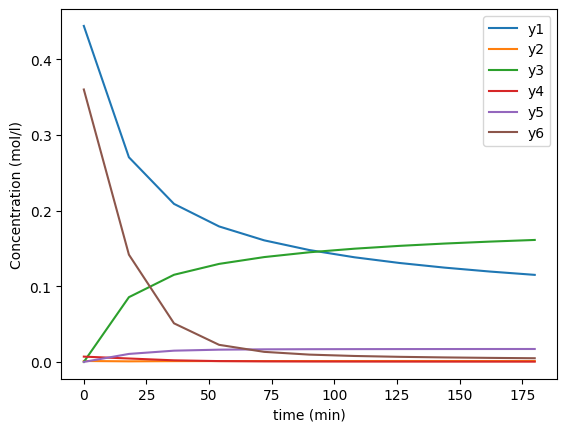

In [9]:
a = plt.plot(m.t, [pyo.value(m.y[t, 1]) for t in m.t], label="y1")
a = plt.plot(m.t, [pyo.value(m.y[t, 2]) for t in m.t], label="y2")
a = plt.plot(m.t, [pyo.value(m.y[t, 3]) for t in m.t], label="y3")
a = plt.plot(m.t, [pyo.value(m.y[t, 4]) for t in m.t], label="y4")
a = plt.plot(m.t, [pyo.value(m.y[t, 5]) for t in m.t], label="y5")
a = plt.plot(m.t, [pyo.value(m.y6[t]) for t in m.t], label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

## Plot Trajectory

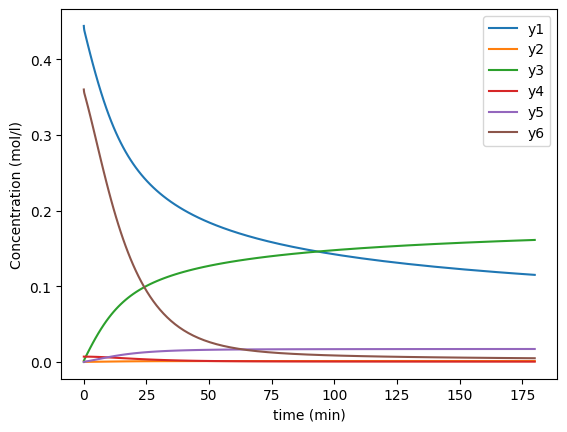

In [10]:
# First plot all y's on one plot

a = plt.plot(tj.time, tj.get_vec(m.y[180, 1]), label="y1")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 3]), label="y3")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 4]), label="y4")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 5]), label="y5")
a = plt.plot(tj.time, tj.get_vec(m.y6[180]), label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

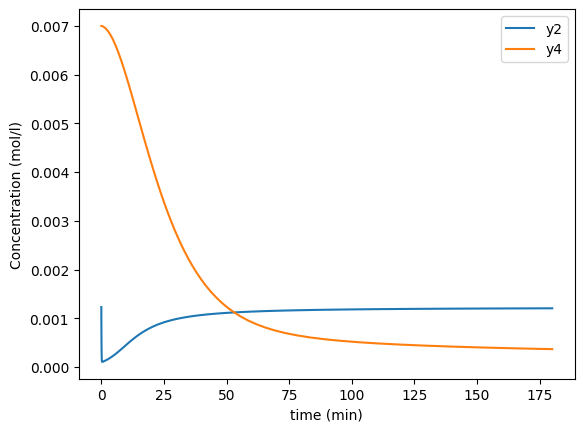

In [11]:
# 2 and 4 are pretty low concentration, so plot those so we can see better
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 4]), label="y4")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

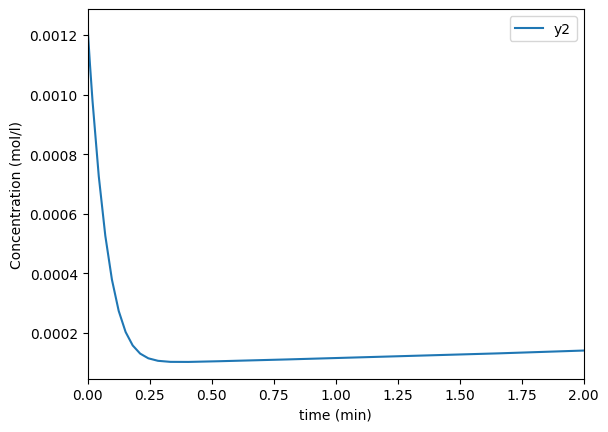

In [12]:
# 2 seems to have some fast dynamics so plot a shorter time
a = plt.plot(tj.vecs["_time"], tj.vecs[str(m.y[180, 2])], label="y2")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")
a = plt.xlim(0, 2)

## Interpolate Trajectory

For a number of reasons, such as initializating Pyomo problems or showing results at even time intervals it can be useful to show values at specific time points.  The PetscTrajectory class has a method to use linear interpolation to produce a new dictionary of trajectory data at specified time points. 

In [13]:
# This creates a new trajectory data set with data every minute.
tji = tj.interpolate(np.linspace(0, 180, 181))

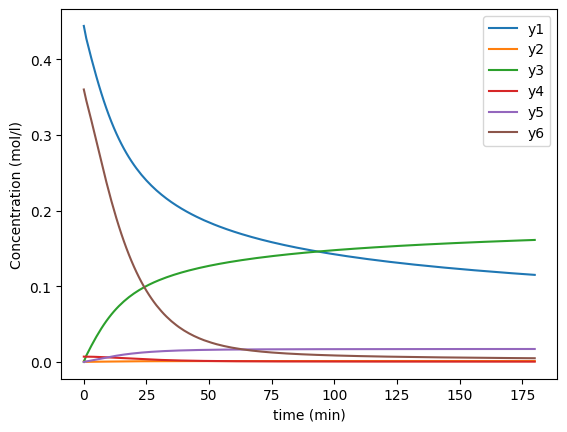

In [14]:
# The plot of this new data should look the same as the original, although some of the
# fast dynamics of component 2 will be obscured.

a = plt.plot(tji.time, tji.get_vec(m.y[180, 1]), label="y1")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 3]), label="y3")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 4]), label="y4")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 5]), label="y5")
a = plt.plot(tji.time, tji.get_vec(m.y6[180]), label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

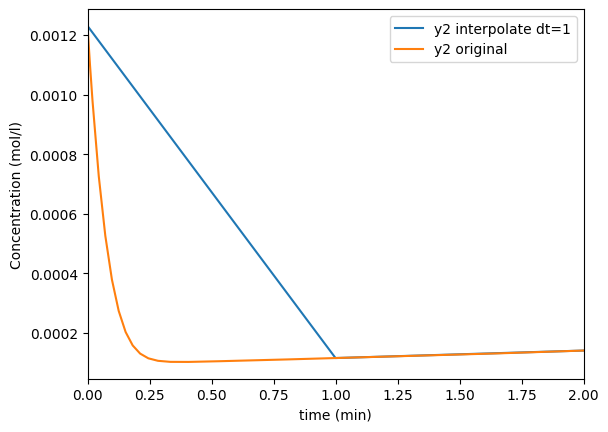

In [15]:
a = plt.plot(tji.time, tji.get_vec(m.y[180, 2]), label="y2 interpolate dt=1")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2 original")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")
a = plt.xlim(0, 2)